<a href="https://colab.research.google.com/github/daje0601/pandas_study/blob/main/_2_%ED%82%A4%EC%9B%8C%EB%93%9C_%EB%B6%84%EC%84%9D(Keyword_Analysis).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 키워드 분석(Keyword Analysis)

* 핵심어(keyword)란 텍스트 자료의 중요한 내용을 압축적으로 제시하는 단어 또는 문구
* 핵심어 분석이란 불용어 제거와 어간추출 및 형태소 분석 등의 자연어 처리를 시행한 후 텍스트에서 많이 등장하는 형태소의 등장 빈도를 분석함으로써 핵심어를 추출   
* 특정 텍스트 자료에 많이 나타나는 형태소가 그 텍스트 주제를 표출할 가능성이 높다는 가정에 기초  
* 물론 빈도 분석에서 영어의 전치사나 한국어의 조사와 같이 의미를 별로 담고 있지 않은 불용어는 제외하는 것이 좋음
* 키워드 분석은 텍스트의 주제 추정, 텍스트 유사도, 검색 엔진의 검색 결과 우선 순위 측정 등 다양하게 사용될 수 있음

## 0. 한글 폰트 설정

* 실행 후 런타임 재시작 필요

In [43]:
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.style.use("seaborn-white")

%config InlineBackend.figure_format="retina"

!apt -qq -y install fonts-nanum

import matplotlib.font_manager as fm 
fontpath = "/user/share/fonts/truetype/nanum/NanumBarunGothic.ttf"
font = fm.FontProperties(fname=fontpath, size=10)
plt.rc("font", family="NanumBarunGothic")
mpl.font_manager._rebuild()

fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


### 한국어 자연어 처리 konlpy와 형태소 분석기 MeCab 설치

* https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh

In [ ]:
!set -x \ 
!pip install konlpy
!curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh | bash -x

약 5분정도 설치가 진행되어, 설치되는 내용이 많이 출력된 내용을 지웠으니 많은 양의 설치가 진행되어도 당황하지 않기!

## 1. 데이터로드 - 네이버 영화 리뷰 데이터

* 키워드 분석에는 네이버 영화 리뷰 데이터를 사용
* 데이터 다운로드: https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt

In [19]:
import urllib.request

raw = urllib.request.urlopen("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt").readlines()
print(raw[:5])

[b'id\tdocument\tlabel\n', b'8112052\t\xec\x96\xb4\xeb\xa6\xb4\xeb\x95\x8c\xeb\xb3\xb4\xea\xb3\xa0 \xec\xa7\x80\xea\xb8\x88\xeb\x8b\xa4\xec\x8b\x9c\xeb\xb4\x90\xeb\x8f\x84 \xec\x9e\xac\xeb\xb0\x8c\xec\x96\xb4\xec\x9a\x94\xe3\x85\x8b\xe3\x85\x8b\t1\n', b'8132799\t\xeb\x94\x94\xec\x9e\x90\xec\x9d\xb8\xec\x9d\x84 \xeb\xb0\xb0\xec\x9a\xb0\xeb\x8a\x94 \xed\x95\x99\xec\x83\x9d\xec\x9c\xbc\xeb\xa1\x9c, \xec\x99\xb8\xea\xb5\xad\xeb\x94\x94\xec\x9e\x90\xec\x9d\xb4\xeb\x84\x88\xec\x99\x80 \xea\xb7\xb8\xeb\x93\xa4\xec\x9d\xb4 \xec\x9d\xbc\xea\xb5\xb0 \xec\xa0\x84\xed\x86\xb5\xec\x9d\x84 \xed\x86\xb5\xed\x95\xb4 \xeb\xb0\x9c\xec\xa0\x84\xed\x95\xb4\xea\xb0\x80\xeb\x8a\x94 \xeb\xac\xb8\xed\x99\x94\xec\x82\xb0\xec\x97\x85\xec\x9d\xb4 \xeb\xb6\x80\xeb\x9f\xac\xec\x9b\xa0\xeb\x8a\x94\xeb\x8d\xb0. \xec\x82\xac\xec\x8b\xa4 \xec\x9a\xb0\xeb\xa6\xac\xeb\x82\x98\xeb\x9d\xbc\xec\x97\x90\xec\x84\x9c\xeb\x8f\x84 \xea\xb7\xb8 \xec\x96\xb4\xeb\xa0\xa4\xec\x9a\xb4\xec\x8b\x9c\xec\xa0\x88\xec\x97\x90 \xeb\x81\x9d

한국어이다보니 위와 같이 출력이 된다. 
이에, 추가적인 decode작업이 필요하다. 

* 데이터를 확인해보면 모두 바이트로 이루어져 있으며, 리뷰 외의 다른 데이터도 존재
* 데이터를 문자열로 변환하고 리뷰만 추출

In [20]:
raw = [x.decode() for x in raw[1:]]

reviews = []
for i in raw :
  reviews.append(i.split('\t')[1])

print(reviews[:3])

['어릴때보고 지금다시봐도 재밌어요ㅋㅋ', '디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업이 부러웠는데. 사실 우리나라에서도 그 어려운시절에 끝까지 열정을 지킨 노라노 같은 전통이있어 저와 같은 사람들이 꿈을 꾸고 이뤄나갈 수 있다는 것에 감사합니다.', '폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.']


## 2. 한국어 토큰화(형태소)


* 형태소 분석기 Mecab으로 명사만 추출
* 형태소 분석기를 통해 조사와 접속사 제거

In [22]:
from konlpy.tag import Mecab

tagger = Mecab()
nouns = [] 
for review in reviews:
  # 명사만 tagger에 통과시켜서 review에서 데이터를 가져오는 작업
  for noun in tagger.nouns(review):
    nouns.append(noun)

nouns[:4]

['때', '디자인', '학생', '외국']

## 3. 형태소(명사) 태깅(PoS)


* 이전 강의에서 POS에 대해 학습을 진행하였다. 그러나, 복습차원에서 한국어로 태깅을 하는 방법을 알아보도록 하자!
* Part-Of-Speech tagging(POS tagging)은 문장 내 단어들의 품사를 식별하여 태그를 붙여주는 것을 말한다.  
* 투플(tuple)의 형태로 출력되며 (단어, 태그[품사(POS)])로 출력된다. 



In [65]:
sentence = " 김치찌개는 맛있는 음식이며, 제가 제일 잘하는 음식입니다. "
print(tagger.pos(sentence))

[('김치찌개', 'NNG'), ('는', 'JX'), ('맛있', 'VA'), ('는', 'ETM'), ('음식', 'NNG'), ('이', 'VCP'), ('며', 'EC'), (',', 'SC'), ('제', 'NP'), ('가', 'JKS'), ('제일', 'MAG'), ('잘', 'MAG'), ('하', 'VV'), ('는', 'ETM'), ('음식', 'NNG'), ('입니다', 'VCP+EF'), ('.', 'SF')]


## 3. 불용어(Stopwords) 사전 만들기

* 형태소 분석을 통해 조사, 접속사 등의 제거 가능
* 하지만 한국어는 명사에서도 상당히 많은 불필요한 단어들이 포함
* 사용자가 직접 불용어 사전을 유지하면서 불필요한 단어 제거 필요
* 불용어 예: `전 난 일 걸 뭐 줄 만 건 분 개 끝 잼 이거 번 중 듯 때 게 내 말 나 수 거 점 것`
* 빈도가 너무 커서 분석에 방해되는 단어도 제거 필요 (예: `영화`)


In [23]:
stop_words = "영화 전 난 일 걸 뭐 줄 만 건 분 개 끝 잼 이거 번 중 듯 때 게 내 말 나 수 거 점 것 그"
stop_words = stop_words.split(" ")
print(stop_words)

['영화', '전', '난', '일', '걸', '뭐', '줄', '만', '건', '분', '개', '끝', '잼', '이거', '번', '중', '듯', '때', '게', '내', '말', '나', '수', '거', '점', '것']


### 3-1. 불용어를 제외하여 형태소 분석 수행

* 한글 텍스트에 대해서 형태소 분석 수행
* 분석으로 추출하는 명사 중에서 불용어에 포함되지 않은 텍스트만 추출하여 저장

In [25]:
nouns = [] 
for review in reviews:
  # 명사만 tagger에 통과시켜서 review에서 데이터를 가져오는 작업
  for noun in tagger.nouns(review):
    # 단, 가져온 명사가 stop_words에 포홤되어 있지 않을 때만 append를 진행함 
    if noun not in stop_words:
      nouns.append(noun)

nouns[:10]

['디자인', '학생', '외국', '디자이너', '그', '전통', '발전', '문화', '산업', '우리']

### 3-2. Spacy에서 제공하는 불용어

In [76]:
import spacy
from spacy.tokenizer import Tokenizer

# Load general-purpose pretrained models to predict named entities, part-of-speech tags and syntactic dependencies
## https://spacy.io/models
## python -m spacy download en_core_web_lg
nlp = spacy.load("en_core_web_sm")

# Tokenizer 생성
tokenizer = Tokenizer(nlp.vocab)

In [82]:
print(nlp.Defaults.stop_words)

{'against', 'would', 'several', 'towards', 'they', 'others', 'make', 'name', 'say', 'various', 'anyone', 'each', 'my', 'move', 'part', 'see', 'will', 'amongst', 'few', 'have', 'third', 'wherein', 'until', 'one', 'whence', 'mostly', 'out', 'up', 'nothing', 'we', 'hereupon', '‘m', 'upon', 'ten', 'sixty', "'d", 'too', 'among', 'front', 'who', 'made', 'using', 'six', 'which', 'either', 'am', 'he', 'nowhere', 'was', 'except', 'own', 'might', 'somehow', 'former', 'at', 'in', 'moreover', 'from', 'to', 'somewhere', 'for', 'regarding', 'empty', 'i', 'such', 'really', 'ca', 'used', 'go', 'whether', 'forty', 'below', 'may', '’d', 'sometime', 'quite', 'formerly', 'bottom', 'anyway', 'had', 'though', '‘d', 'same', 'along', 'everyone', 'no', 'whoever', 'whereafter', '’re', 'around', 'nine', 'namely', 'if', 'most', 'that', '’ve', 'per', 'yourselves', 'seemed', 'hereafter', 'what', 'already', 'any', 'latterly', 'did', 'therein', 'him', 'else', 'side', 'four', 'does', 'via', 'into', '’s', 'elsewhere', 

* 이렇게 기본적으로 제공하는 stop_words에 내가 원하는 stop_words를 추가하려면 아래와 같이 작성하면 된다. 

In [83]:
STOP_WORDS = nlp.Defaults.stop_words.union(['batteries','I', 'amazon', 'i', 'Amazon'])

## 4. 단어 빈도수 측정

* 단어 빈도수 측정에는 `collections` 라이브러리의 `Counter` 함수를 이용
* `collections` 라이브러리는 내장 라이브러리로 별도 설치가 필요없음
* `counter`를 이용하면 각 단어와 각 단어의 빈도 수를 딕셔너리로 편리하게 생성 가능

In [56]:
from collections import Counter

nouns_counter = Counter(nouns)
top_nouns = dict(nouns_counter.most_common(100))
top_nouns

{'ㄷ': 1791,
 '가슴': 1817,
 '가족': 1401,
 '감독': 5629,
 '감동': 6489,
 '개봉': 1248,
 '건지': 1397,
 '결말': 2066,
 '공감': 1288,
 '공포': 2048,
 '굿': 2110,
 '그': 1410,
 '극장': 1290,
 '급': 1632,
 '기대': 3465,
 '기분': 1241,
 '기억': 2364,
 '나라': 1409,
 '남자': 2078,
 '내용': 5731,
 '년': 4936,
 '눈': 1484,
 '눈물': 1704,
 '느낌': 1950,
 '대박': 1495,
 '대사': 1263,
 '데': 1707,
 '돈': 2980,
 '드라마': 6896,
 '때문': 2371,
 '마음': 2128,
 '마지막': 3647,
 '매력': 1832,
 '명작': 2685,
 '모습': 1364,
 '몰입': 1453,
 '뭔가': 1361,
 '밋': 1820,
 '반전': 1868,
 '배우': 5893,
 '부분': 1246,
 '뿐': 1429,
 '사람': 6742,
 '사랑': 4741,
 '생각': 6943,
 '소재': 1999,
 '속': 1738,
 '수준': 1864,
 '스토리': 7163,
 '시간': 5320,
 '시리즈': 1380,
 '실망': 1557,
 '쓰레기': 4585,
 '씨': 1902,
 '아이': 1749,
 '애': 2730,
 '액션': 3568,
 '여운': 1386,
 '여자': 2678,
 '연기': 9175,
 '연기력': 1387,
 '연출': 2376,
 '우리': 2531,
 '원작': 1705,
 '음악': 1852,
 '이': 1560,
 '이건': 3650,
 '이걸': 1264,
 '이게': 3046,
 '이상': 2676,
 '이야기': 2947,
 '이해': 2745,
 '인간': 1811,
 '인생': 2060,
 '일본': 1878,
 '자체': 1558,
 '작품': 3985,
 '장면':

## 4. 단어 빈도 시각화

### 4-1. hist그램을 이용한 시각화


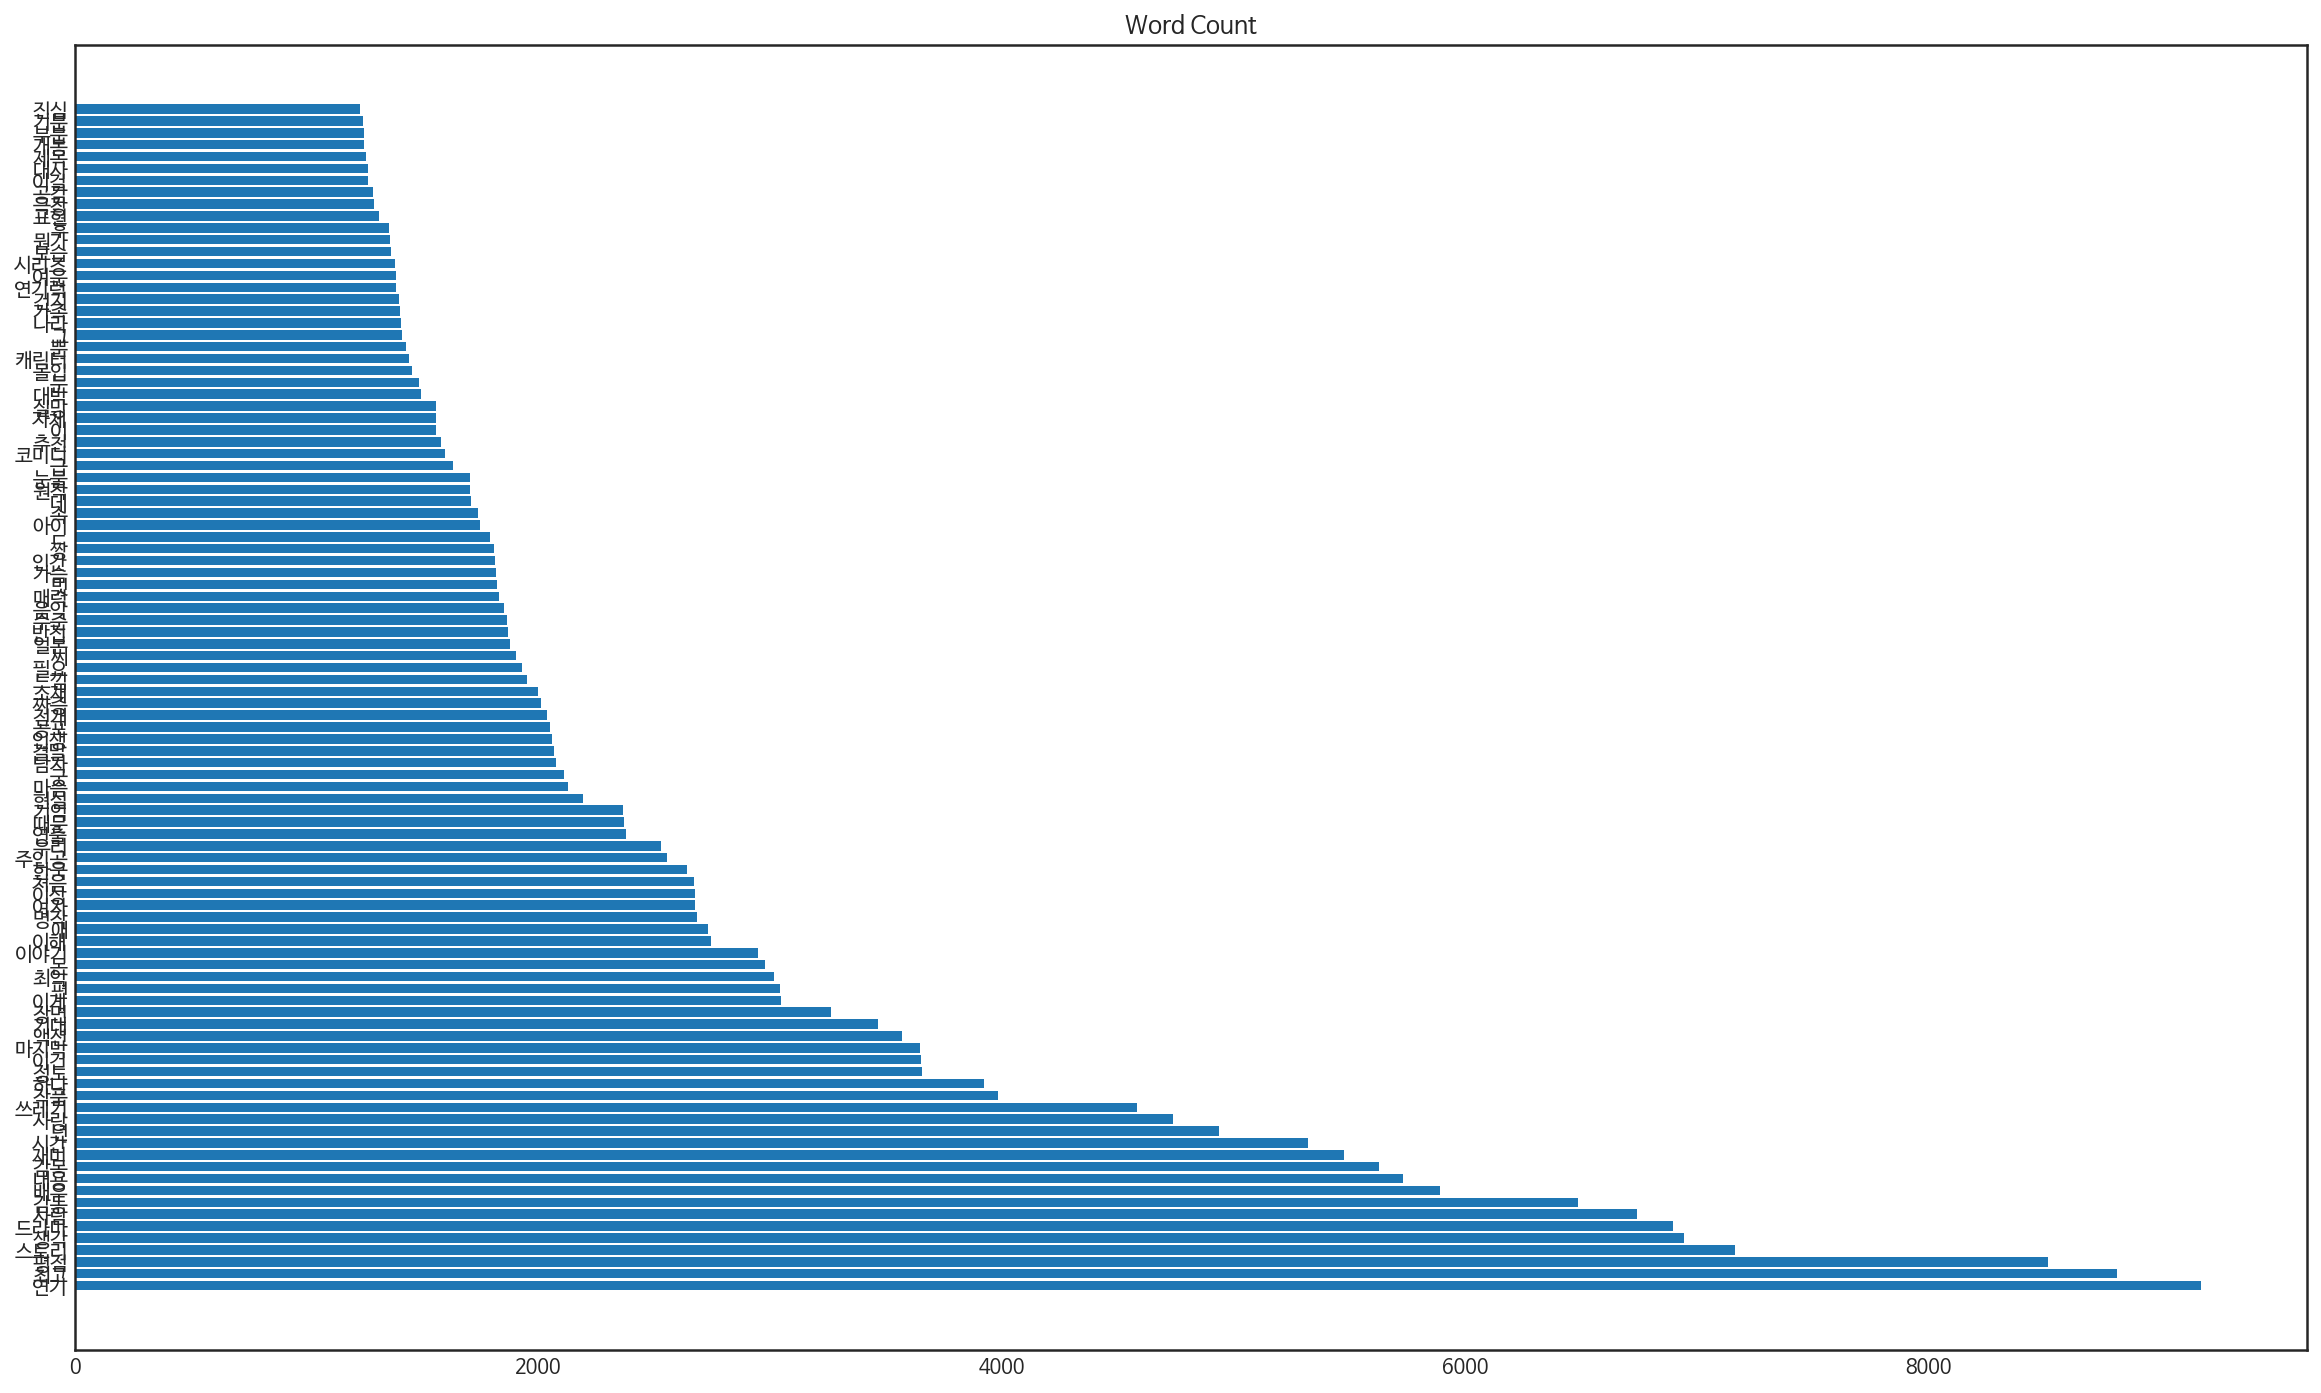

In [59]:
import numpy as np

y_pos = np.arange(len(top_nouns))

plt.figure(figsize=(20, 12))
plt.barh(y_pos, top_nouns.values())
plt.title("Word Count")
plt.yticks(y_pos, top_nouns.keys())
plt.show()

### 4-2. 워드클라우드(WordCloud)

* 텍스트에 담겨있는 여러 형태소들의 등장 빈도를 가장 직관적으로 시각화하는 방법
* 텍스트에 등장하는 단어를 그 등장 빈도에 따라 서로 크기가 다르게 구름 형태로 표현함으로써, 단어의 빈도 수를 한번에 알 수 있음  
* 최근에 많은 서비스들이 어떤 핵심어가 많이 등장했는가를 워드클라우드 형식으로 시각화
* 빈도 수만을 시각적으로 표현한 것이기 때문에, 단어들 사이의 연관성이나 의미 구조 등을 분석하는 데는 한계가 있음

* 파이썬에서 워드 클라우드를 시각화하기 위해 `matplotlib` 라이브러리와 `WordCloud` 라이브러리를 `import` 해서 사용
* `WordCloud` 라이브러리는 `pip install wordcloud` 명령어를 통해 설치 필요

In [49]:
!pip install wordcloud

* WordCloud를 이용해 객체를 생성해주고,
`generate_from_frequencies()` 함수로 빈도 수에 따라 워드클라우드 생성

In [60]:
from wordcloud import WordCloud

# 한글이 포함되어 있기 때문에 font_path를 필수로 지정해주어야한다. 
wc = WordCloud(background_color="white", font_path="./font/NanumBarunGothic.ttf")

# wordcloud 객체 생성 
wc.generate_from_frequencies(top_nouns)

* 워드클라우드를 시각화할 때는 이미지 시각화 함수인 `imshow()` 함수를 사용해야 함

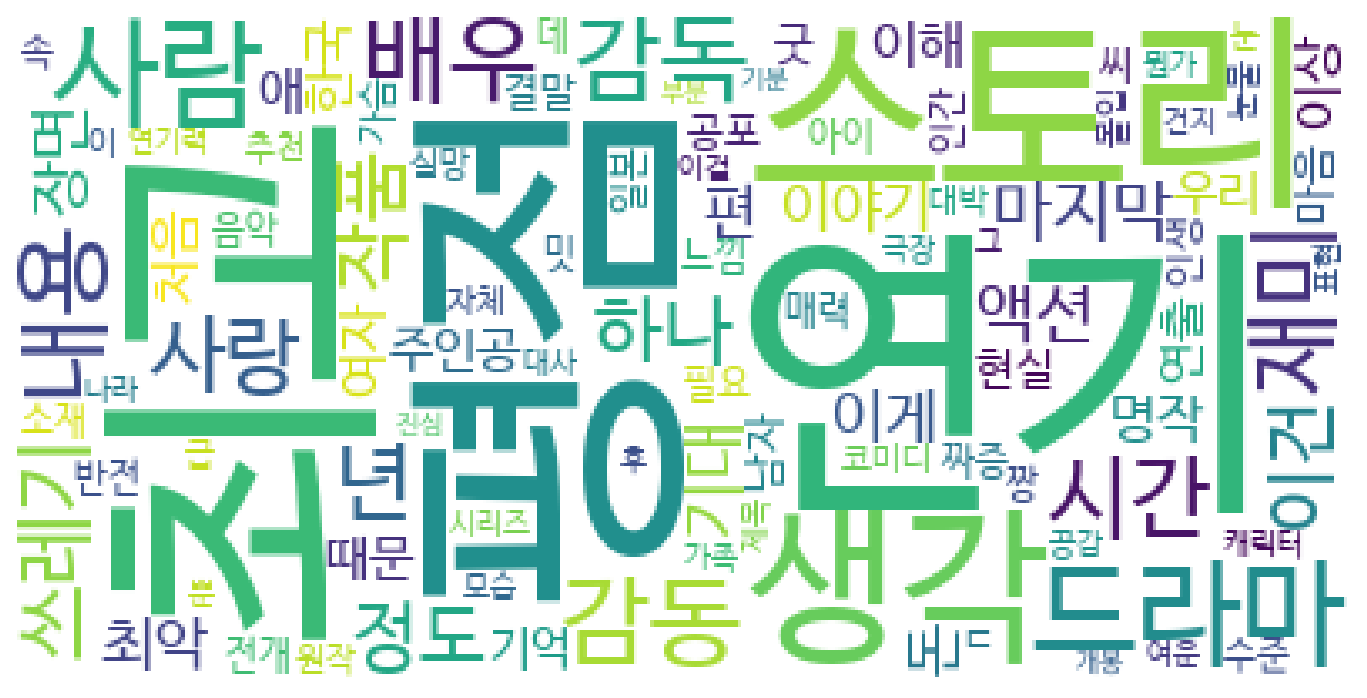

In [61]:
figure= plt.figure(figsize=(12,12))
ax = figure.add_subplot(1,1,1)
ax.axis("off")
ax.imshow(wc)
plt.show()

### 4-3. squarify 트리맵 시각화

* `squarify`는 트리맵 생성을 지원해주는 파이썬 라이브러리
* `squarify` 라이브러리를 이용해 키워드와 키워드 빈도 수를 트리맵으로 나타냄   

In [62]:
!pip install squarify

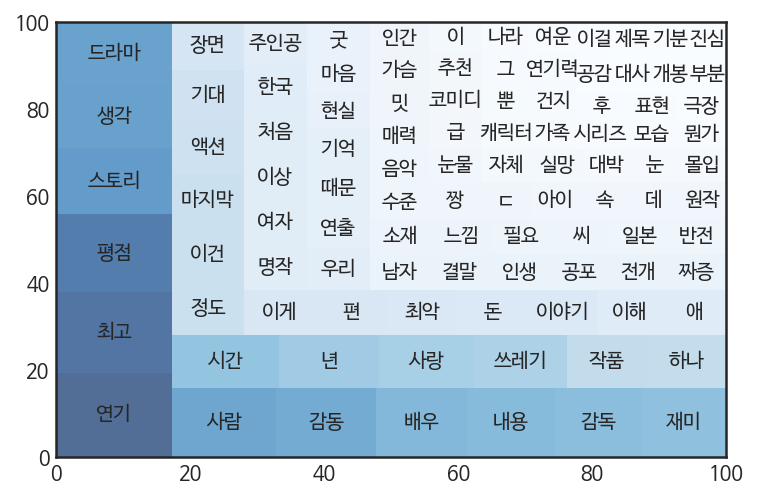

In [69]:
import squarify

#출력하기 전 카운트된 숫자들을 normalize를 해줘야한다. 
norm = mpl.colors.Normalize(vmin=min(top_nouns.values()),
                            vmax=max(top_nouns.values()))
# 색깔 지정 
# 카운트 된 숫자에 따라서 색상의 진해지는 정도를 결정해주는 코드 
colors = [mpl.cm.Blues(norm(value)) for value in top_nouns.values()]

squarify.plot(label=top_nouns.keys(),
              sizes=top_nouns.values(),
              color=colors,
              alpha=.7);

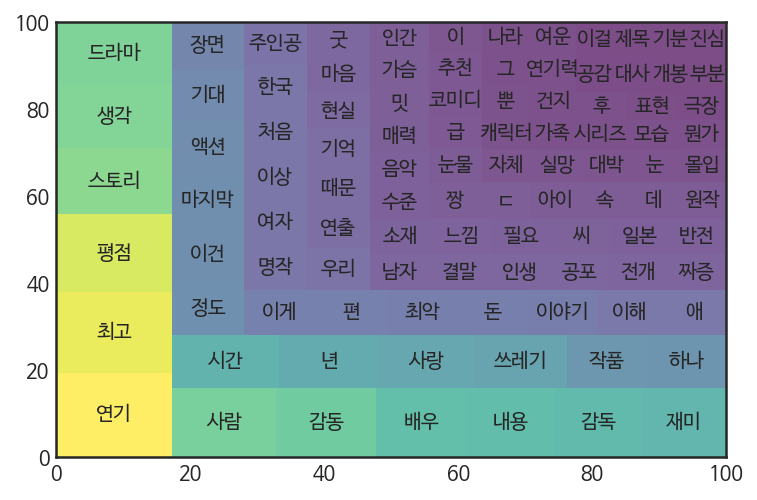

In [70]:
# 위 내용과 같은데 이렇게 컬러에 대한 설정만 바꾸어주어도 다른 이미지가 출력이 된다. 
import squarify

#출력하기 전 카운트된 숫자들을 normalize를 해줘야한다. 
norm = mpl.colors.Normalize(vmin=min(top_nouns.values()),
                            vmax=max(top_nouns.values()))
# 색깔 지정 
# 카운트 된 숫자에 따라서 색상의 진해지는 정도를 결정해주는 코드 
colors = [mpl.cm.viridis(norm(value)) for value in top_nouns.values()]

squarify.plot(label=top_nouns.keys(),
              sizes=top_nouns.values(),
              color=colors,
              alpha=.7);

---

## 5. 만약 데이터프레임에 있다면 어떤식으로 분석을 진행해야할까?

In [84]:
import pandas as pd
df = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/amazon/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19_sample.csv')

* 데이터프레임 형식으로 column에 우리가 분석하고자 하는 값이 있다면 아래와 같이 분석을 진행할 수 있다. 

In [85]:
df.head(2)

,Unnamed: 0,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,manufacturer,manufacturerNumber,reviews.date,reviews.dateSeen,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
0,25971,AVqkIhxunnc1JgDc3kg_,2017-03-06T14:59:43Z,2019-02-23T02:49:38Z,"Fire HD 8 Tablet with Alexa, 8 HD Display, 16 ...",B018T075DC,Amazon,"Fire Tablets,Tablets,All Tablets,Amazon Tablet...",Electronics,https://www.upccodesearch.com/images/barcode/0...,"amazon/b018t075dc,firehd8tabletwithalexa8hddis...",Amazon,53-004485,2017-01-18T00:00:00.000Z,"2017-04-30T00:00:00Z,2017-06-07T00:00:00Z",NaN,True,NaN,0.0,3,http://reviews.bestbuy.com/3545/5620410/review...,Though I have got it for cheap price during bl...,An average Fire tablet,Ganamurthy,http://reviews.bestbuy.com/3545/5620410/review...
1,19398,AVwjfXqqQMlgsOJE8qmm,2017-05-20T01:34:04Z,2019-02-25T02:23:15Z,"All-New Fire HD 8 Kids Edition Tablet, 8 HD Di...",B01J94SCAM,Amazon,"Fire Tablets,Tablets,Amazon Tablets,Computers ...",Electronics,https://www.barcodable.com/images/barcode/0841...,amazonfirehd8kidsedition8tablet32gb7thgenerati...,Amazon,53-005705,2017-06-22T00:00:00.000Z,"2018-05-27T00:00:00Z,2017-07-07T00:00:00Z,2017...",NaN,True,NaN,17.0,5,http://reviews.bestbuy.com/3545/5836204/review...,"I purchased the 7"" for my son when he was 1.5 ...",3 year old loves it,dcc1970,https://reviews.bestbuy.com/3545/5836204/revie...


In [86]:
# 정규식 라이브러리
import re

# 정규식
# []: [] 사이 문자를 매치, ^: not
regex = r"[^a-zA-Z0-9 ]"

# 치환할 문자
subst = ""

def tokenize(text):
    """
    text 문자열을 의미있는 단어 단위로 list에 저장합니다.
    Args : text (str): 토큰화 할 문자열
    Returns : list: 토큰이 저장된 리스트
    """
    # 정규식 적용
    tokens = re.sub(regex, subst, text)

    # 소문자로 치환
    tokens = tokens.lower().split()
    
    return tokens

In [87]:
df['tokens'] = df['reviews.text'].apply(tokenize)

In [88]:
df[['reviews.text', 'tokens']][:5]

,reviews.text,tokens
0,Though I have got it for cheap price during bl...,"[though, i, have, got, it, for, cheap, price, ..."
1,"I purchased the 7"" for my son when he was 1.5 ...","[i, purchased, the, 7, for, my, son, when, he,..."
2,Great price and great batteries! I will keep o...,"[great, price, and, great, batteries, i, will,..."
3,Great tablet for kids my boys love their table...,"[great, tablet, for, kids, my, boys, love, the..."
4,They lasted really little.. (some of them) I u...,"[they, lasted, really, little, some, of, them,..."


In [89]:
# Counter 객체는 리스트요소의 값과 요소의 갯수를 카운트 하여 저장하고 있습니다.
# 카운터 객체는 .update 메소드로 계속 업데이트 가능합니다.
word_counts = Counter()

# 토큰화된 각 리뷰 리스트를 카운터 객체에 업데이트 합니다. 
df['tokens'].apply(lambda x: word_counts.update(x))

# 가장 많이 존재하는 단어 순으로 10개를 나열합니다
word_counts.most_common(10)

[('the', 10514),
 ('and', 8137),
 ('i', 7465),
 ('to', 7150),
 ('for', 6617),
 ('a', 6421),
 ('it', 6096),
 ('my', 4119),
 ('is', 4111),
 ('this', 3752)]

* 또는 이렇게 함수를 만들어서 한번에 처리를 할 수도 있다. 
* 사용하고자 하실 때는 주석을 제거하고 사용하시면 됩니다.

In [72]:
def word_count(docs):
    """ 토큰화된 문서들을 입력받아 토큰을 카운트 하고 관련된 속성을 가진 데이터프레임을 리턴합니다.
    Args:
        docs (series or list): 토큰화된 문서가 들어있는 list
    Returns:
        list: Dataframe
    """
    # 전체 코퍼스에서 단어 빈도 카운트
    word_counts = Counter()

    # 단어가 존재하는 문서의 빈도 카운트, 단어가 한 번 이상 존재하면 +1
    word_in_docs = Counter()

    # 전체 문서의 갯수
    total_docs = len(docs)

    for doc in docs:
        word_counts.update(doc)
        word_in_docs.update(set(doc))

    temp = zip(word_counts.keys(), word_counts.values())

    wc = pd.DataFrame(temp, columns = ['word', 'count'])

    # 단어의 순위
    # method='first': 같은 값의 경우 먼저나온 요소를 우선
    wc['rank'] = wc['count'].rank(method='first', ascending=False)
    total = wc['count'].sum()

    # 코퍼스 내 단어의 비율
    wc['percent'] = wc['count'].apply(lambda x: x / total)

    wc = wc.sort_values(by='rank')

    # 누적 비율
    # cumsum() : cumulative sum
    wc['cul_percent'] = wc['percent'].cumsum()

    temp2 = zip(word_in_docs.keys(), word_in_docs.values())
    ac = pd.DataFrame(temp2, columns=['word', 'word_in_docs'])
    wc = ac.merge(wc, on='word')
    
    # 전체 문서 중 존재하는 비율
    wc['word_in_docs_percent'] = wc['word_in_docs'].apply(lambda x: x / total_docs)

    return wc.sort_values(by='rank')

In [91]:
import pandas as pd

wc = word_count(df['tokens'])
wc.head(3)

,word,word_in_docs,count,rank,percent,cul_percent,word_in_docs_percent
74,the,4909,10514,1.0,0.039353,0.039353,0.468282
4,and,5064,8137,2.0,0.030456,0.069809,0.483068
20,i,3781,7465,3.0,0.027941,0.097750,0.360679


0.9097585076280484

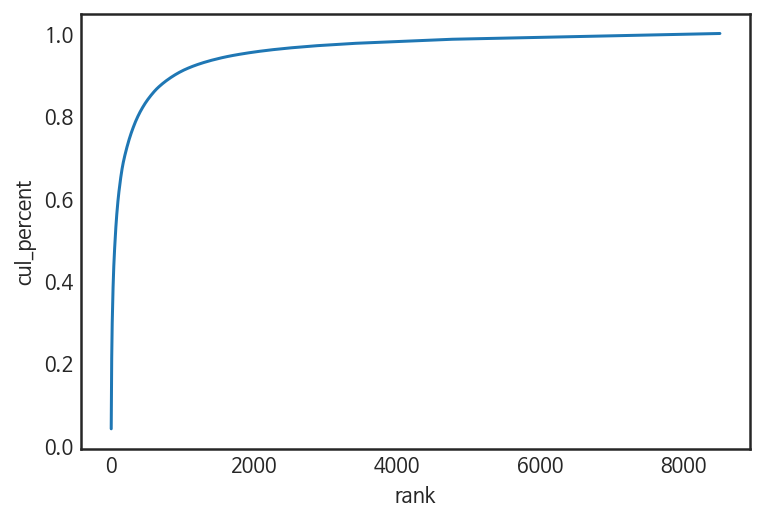

In [92]:
import seaborn as sns

# 누적분포그래프(CDF)
sns.lineplot(x='rank', y='cul_percent', data=wc);
wc[wc['rank'] <= 1000]['cul_percent'].max()

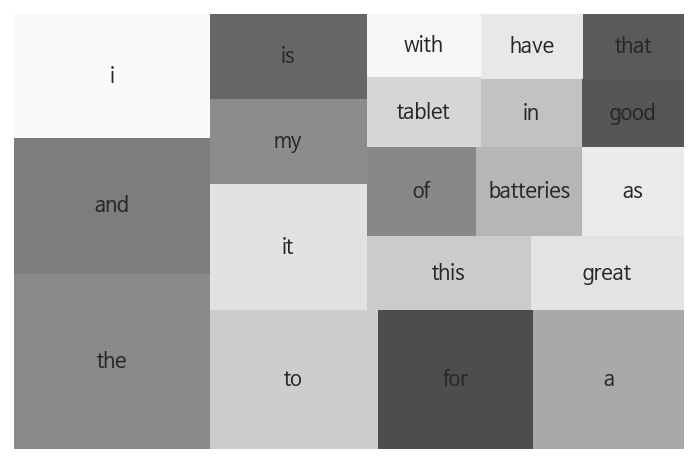

In [93]:
wc_top20 = wc[wc['rank'] <= 20]

color=['viridis']

squarify.plot(sizes=wc_top20['percent'], label=wc_top20['word'], alpha=0.7 )
plt.axis('off')
plt.show()

* 불용어를 제거하지 않아서 엉뚱한 단어들이 우선순위에 들어있는 것을 볼 수 있다. 
* 이제 불용어를 제거하고 한번 다시 관찰해보자 

In [94]:
tokens = []
# 토큰에서 불용어 제거, 소문자화 하여 업데이트
for doc in tokenizer.pipe(df['reviews.text']):
    doc_tokens = []

    # A doc is a sequence of Token(<class 'spacy.tokens.doc.Doc'>)
    for token in doc:
        # 토큰이 불용어와 구두점이 아니면 저장
        if (token.is_stop == False) & (token.is_punct == False):
            doc_tokens.append(token.text.lower())

    tokens.append(doc_tokens)

df['tokens'] = tokens

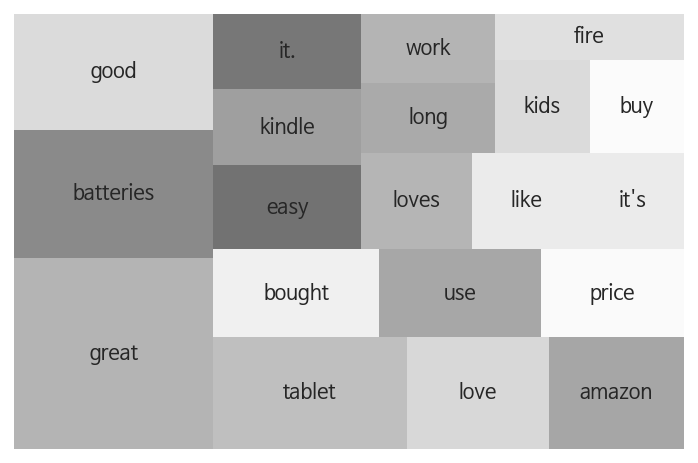

In [95]:
wc = word_count(df['tokens'])

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['percent'], label=wc_top20['word'], alpha=0.6)
plt.axis('off')
plt.show()

* 위 그럼보다 훨씬 의미있는 데이터들이 확인되는 것을 볼 수 있습니다. 
  
* 그렇다면 이렇게만 하면 끝일까요?
* 정답은 아닙니다! 
* 일단, 통계적인 분포를 확인해야합니다. 1개 있는 단어들이 많을 수도 있으니까 그런 부분을 확인을 하고!
* 복수형, 진행형 등으로 단어의 수가 늘어나 있는 경우가 있을 수 있습니다. 이런 단어를 처리해주는 작업을 진행해야합니다. 
* 이런 작업을 
표제어추출(lemmatization)과 어간추출(stemming)이라고 합니다. 

### 5-1. 통계적 분석

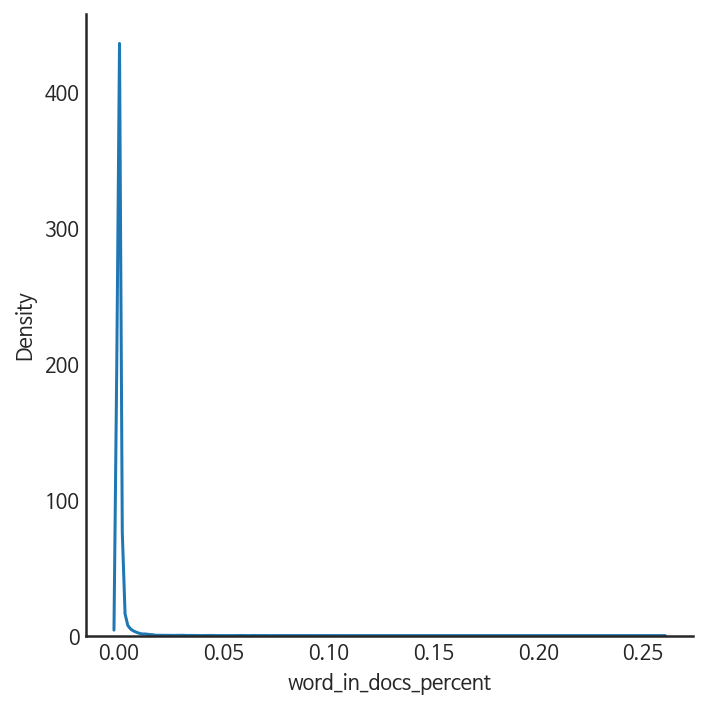

In [96]:
# 문서에 나타나는 빈도
sns.displot(wc['word_in_docs_percent'],kind='kde');

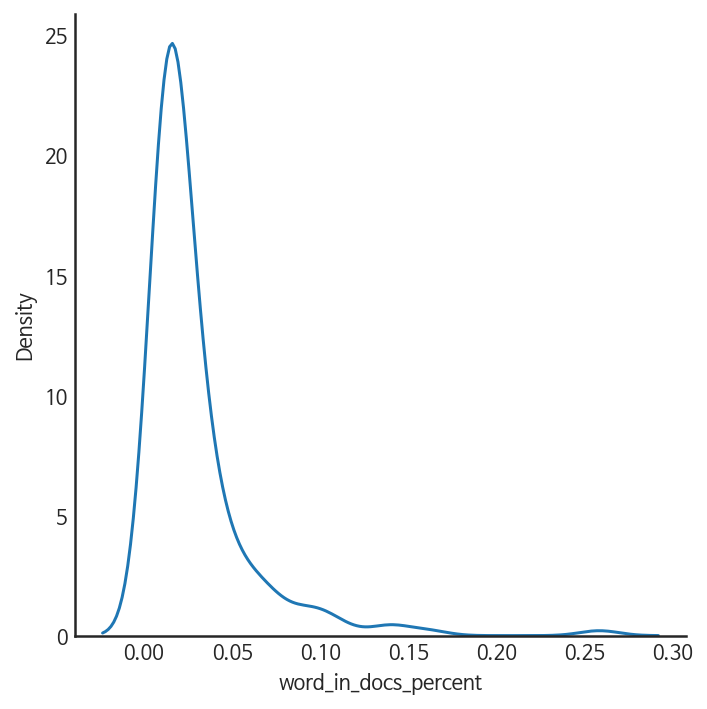

In [97]:
# 최소한 1% 이상 문서에 나타나는 단어들만 선택합니다.

wc = wc[wc['word_in_docs_percent'] >= 0.01]

sns.displot(wc['word_in_docs_percent'], kind='kde');

* 1%이상의 단어들만 선택하였을 때 훨씬 그래프의 왜도가 움직이는 것을 볼 수 있네요

### 5-2. steming

In [98]:
from nltk.stem import PorterStemmer

ps = PorterStemmer()

tokens = []
for doc in df['tokens']:
    doc_tokens = []
    for token in doc:
        doc_tokens.append(ps.stem(token))
    tokens.append(doc_tokens)

df['stems'] = tokens

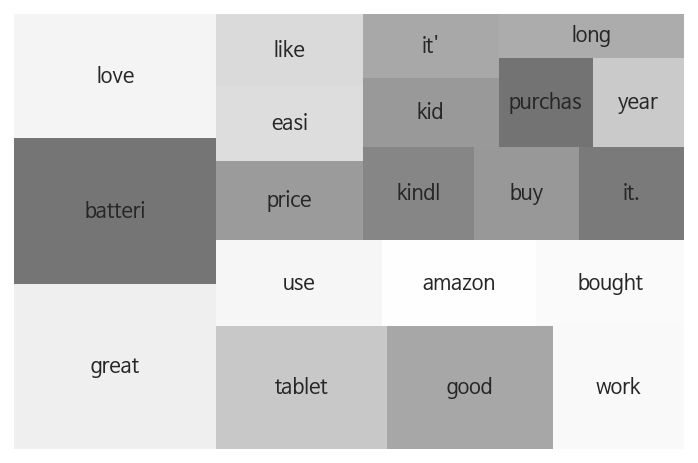

In [99]:
wc = word_count(df['stems'])

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['percent'], label=wc_top20['word'], alpha=0.6 )
plt.axis('off')
plt.show()

### 5-3. Lemmatization

In [101]:

# Lemmatization 과정을 함수로 만들어 봅시다
def get_lemmas(text):

    lemmas = []
    
    doc = nlp(text)

    for token in doc: 
        if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_ != 'PRON'):
            lemmas.append(token.lemma_)
    
    return lemmas

* 여기에서 lematation을 할때 원본데이터로 시작하는 이유는 lemmas에 들어갈 데이터가 반드시 str형식이여야 하기 때문입니다. 
* 기존에 만든 df["tokens"]은 이미 토큰화가된 list형식이기 때문에 사용할 수 없습니다. 

In [103]:
df['lemmas'] = df['reviews.text'].apply(get_lemmas)

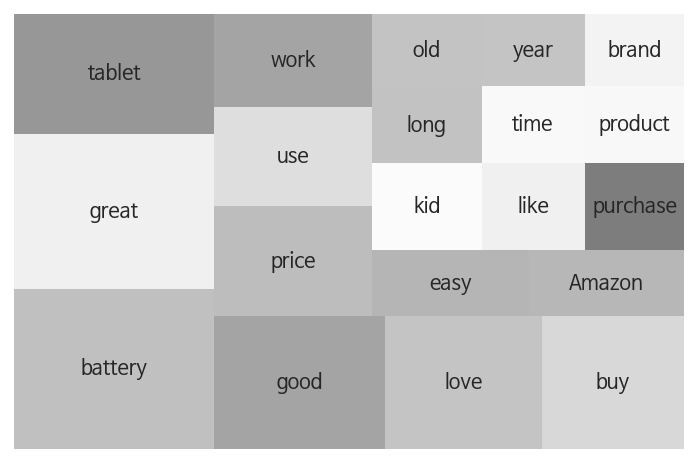

In [104]:
wc = word_count(df['lemmas'])
wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['percent'], label=wc_top20['word'], alpha=0.6 )
plt.axis('off')
plt.show()